### Import Library

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import itertools
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [2]:
X = pd.read_csv('dataset/fitur.csv').values
X

array([[0.5137741 , 0.74558996, 0.78156792, 0.20550526],
       [0.59937033, 0.65895727, 0.78575703, 0.28307523],
       [0.48248721, 0.67346139, 0.80670257, 0.25265383],
       ...,
       [0.48465171, 0.03606429, 0.09694794, 0.0706769 ],
       [0.454939  , 0.24382595, 0.3967684 , 0.07145811],
       [0.67827627, 0.81575853, 0.7432675 , 0.49119985]])

In [3]:
y = pd.read_csv('dataset/target.csv').values
y

array([[0.70550539],
       [0.73579959],
       [0.71103991],
       ...,
       [0.20128168],
       [0.40576755],
       [0.8311972 ]])

### Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Modeling

##### Inisialisasi bobot dan bias

In [5]:
def inisialisasi(hidden_layer, hidden_neuron):
    bobot = []
    bias = []
    for i in range(hidden_layer):
        if i == 0:
            bobot.append(np.random.rand(4, hidden_neuron[i]).tolist())
        else:
            bobot.append(np.random.rand(hidden_neuron[i-1], hidden_neuron[i]).tolist())
        bias.append(np.random.rand(hidden_neuron[i]).tolist())
    bobot_output = np.random.rand(hidden_neuron[-1]).tolist()
    bias_output = np.random.rand()
    return bobot, bias, bobot_output, bias_output

##### Fungsi aktivasi

In [6]:
def relu(x):
    if x > 0:
        return x
    else:
        return 0

def turunan_relu(x):
    if x > 0:
        return 1
    else:
        return 0 

##### Fungsi Training

In [7]:
def ann(epochs, hidden_layer, hidden_neuron, lr, X_train, y_train):
    bobot, bias, bobot_output, bias_output = inisialisasi(hidden_layer, hidden_neuron)
    best_mse = float('inf')
    best_bobot = bobot
    best_bias = bias
    best_bobot_output = bobot_output
    best_bias_output = bias_output
    for epoch in range(epochs):
        total_error = 0
        for i in range(len(X_train)):
            # FEEDFORWARD
            # Operasi pada Hidden Layer
            # penjumlahan terbobot dan aktivasi
            aktivasi_hidden = [] # menampung keseluruhan aktivasi
            for j in range(hidden_layer):
                aktivasi_hidden_temp = [] # menampung aktivasi setiap hiden layer (sementara)
                for k in range(hidden_neuron[j]):
                    sumXbobot = 0 # hasil penjumlahan terbobot
                    if j == 0: # untuk hidden neuron pertama (karena neuron input tidak terdefinisi)
                        for l in range(4): # jumlah neuron layer sebelumnya/ neuron input = 4
                            sumXbobot += bobot[j][l][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]): # jumlah neuron layer sebelumnya
                            sumXbobot += bobot[j][l][k] * aktivasi_hidden[j-1][l]
                    # menambahkan bias pada hasil penjumlahan terbobot
                    sumXbobotbias = bias[j][k] + sumXbobot
                    # aktivasi
                    aktivasi_hidden_temp.append(relu(sumXbobotbias))
                # menambahkan hasil aktivasi tiap hidden_layer ke penampung keseluruhan
                aktivasi_hidden.append(aktivasi_hidden_temp)

            # Operasi pada Output Layer
            # perkalian
            sumZbobotoutput = 0 # hasil penjumlahan terbobot di output layer
            for j in range(hidden_neuron[-1]):
                sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
            # menambahkan bias pada hasil penjumlahan terbobot di output layer
            sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
            # aktivasi
            prediksi = relu(sumZbobotoutput_biasoutput)

            # Hitung Error (total error untuk menghitung MSE)
            error = y_train[i][0] - prediksi
            total_error += (error ** 2)

        # BACKPROPAGATION
        # error output layer
        error_output = error * turunan_relu(prediksi)
        # inisialisasi error setiap neuron di hidden layer
        error_nuron_hidden = []
        for i in range(hidden_layer):
            error_nuron_hidden.append(np.zeros(hidden_neuron[i]).tolist())
        # error setiap neuron di hidden layer
        for i in range(hidden_layer):
            for j in range(hidden_neuron[-(i+1)]): # mulai dari hidden layer terakhir
                if i == 0: # hidden terakhir akan melibatkan error output
                    sumErrorBobotSetelah = 0
                    sumErrorBobotSetelah += error_output * bobot_output[j]
                    # sum dikalikan turunan input
                    error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
                else:
                    sumErrorBobotSetelah = 0
                    for k in range(hidden_neuron[-(i)]): # hidden layer yang 1 lebihnya
                        sumErrorBobotSetelah += error_nuron_hidden[-(i)][k] * bobot[-(i)][j][k]
                        # sum dikalikan turunan input
                        error_nuron_hidden[-(i+1)][j] = sumErrorBobotSetelah * turunan_relu(aktivasi_hidden[-(i+1)][j]) 
        # memperbaiki bobot dan bias
        for i in range(len(X_train)):
            for j in range(hidden_layer):
                for k in range(hidden_neuron[j]):
                    # memperbaiki bobot
                    if j == 0:
                        for l in range(4):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * X_train[i][l]
                    else:
                        for l in range(hidden_neuron[j-1]):
                            bobot[j][l][k] += lr * error_nuron_hidden[j][k] * aktivasi_hidden[j-1][l]
                # memperbaiki bias
                bias[j][k] += lr * error_nuron_hidden[j][k]
        # memperbaiki bobot output
        for i in range(len(bobot_output)):
            bobot_output[i] += lr * error_output * aktivasi_hidden[-1][i]
        # memperbaiki bias output
        bias_output += lr * error_output

        # RATA-RATA ERROR
        mse = total_error / len(X_train)
        epoch_sekarang = epoch + 1
        print(f"Epoch {epoch_sekarang}, MSE: {mse}")
        if best_mse > mse:
            best_mse = mse
            best_bobot = bobot
            best_bias = bias
            best_bobot_output = bobot_output
            best_bias_output = bias_output
    print("PELATIHAN SELESAI\n\n")

    return best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output

##### Training + Tuning

In [8]:
hidden_layer = 2
hidden_neuron = [2, 2]
lr = 0.005
epoch = 100

best_mse, best_bobot, best_bias, best_bobot_output, best_bias_output = ann(epoch, hidden_layer, hidden_neuron, lr, X_train, y_train)

Epoch 1, MSE: 2.5657014352321252
Epoch 2, MSE: 0.023267337954125687
Epoch 3, MSE: 0.023179521835297135
Epoch 4, MSE: 0.02309250527225636
Epoch 5, MSE: 0.023006280326017044
Epoch 6, MSE: 0.022920839141040525
Epoch 7, MSE: 0.0228361739443301
Epoch 8, MSE: 0.022752277044532823
Epoch 9, MSE: 0.022669140831054146
Epoch 10, MSE: 0.022586757773179113
Epoch 11, MSE: 0.02250512041920711
Epoch 12, MSE: 0.022424221395592178
Epoch 13, MSE: 0.022344053406095497
Epoch 14, MSE: 0.02226460923094705
Epoch 15, MSE: 0.02218588172601466
Epoch 16, MSE: 0.022107863821985253
Epoch 17, MSE: 0.022030548523551623
Epoch 18, MSE: 0.021953928908611735
Epoch 19, MSE: 0.02187799812747401
Epoch 20, MSE: 0.02180274940207278
Epoch 21, MSE: 0.021728176025192926
Epoch 22, MSE: 0.021654271359701025
Epoch 23, MSE: 0.02158102883778767
Epoch 24, MSE: 0.021508441960215702
Epoch 25, MSE: 0.021436504295578928
Epoch 26, MSE: 0.02136520947956651
Epoch 27, MSE: 0.021294551214238577
Epoch 28, MSE: 0.021224523267306623
Epoch 29, MSE

In [9]:
def tuning_hyperparameters(X_train, y_train):
    hidden_layer_values = [1, 2]
    neuron_values = [1, 2, 3, 4, 5]
    lr_values = [0.005, 0.01]
    epoch_values = [200, 500]

    hidden_layer_list = []
    hidden_neuron_list = []
    lr_list = []
    epoch_list = []
    mse_list = []
    bobot_list = []
    bias_list = []
    bobot_output_list = []
    bias_output_list = []
    i = 0
    # Looping semua kombinasi
    for hidden_layer in hidden_layer_values:
        # Kombinasi neuron berdasarkan jumlah hidden layers
        for hidden_neuron_combination in itertools.product(neuron_values, repeat=hidden_layer):
            for lr in lr_values:
                for epoch in epoch_values:
                    i += 1
                    print(f"KOMBINASI KE-{i}\nHIDDEN LAYER={hidden_layer}, HIDDEN NEURON={tuple(hidden_neuron_combination)}, LR={lr}, EPOCH={epoch}")
                    mse, bobot, bias, bobot_output, bias_output = ann(epoch, hidden_layer, list(hidden_neuron_combination), lr, X_train, y_train)
                    hidden_layer_list.append(hidden_layer)
                    hidden_neuron_list.append(tuple(hidden_neuron_combination))
                    lr_list.append(lr)
                    epoch_list.append(epoch)
                    mse_list.append(mse)
                    bobot_list.append(bobot)
                    bias_list.append(bias)
                    bobot_output_list.append(bobot_output)
                    bias_output_list.append(bias_output)
    # Menggabungkan list yang ada menjadi dictionary
    data = {
        'hidden_layer': hidden_layer_list,
        'hidden_neuron': hidden_neuron_list,
        'lr': lr_list,
        'epoch': epoch_list,
        'mse': mse_list,
        'bobot': bobot_list,
        'bias': bias_list,
        'bobot_output': bobot_output_list,
        'bias_output': bias_output_list
    }
    tuning = pd.DataFrame(data)

    return tuning

##### Pemanggilan fungsi tuning

In [10]:
tuning = tuning_hyperparameters(X_train, y_train)

KOMBINASI KE-1
HIDDEN LAYER=1, HIDDEN NEURON=(1,), LR=0.005, EPOCH=200
Epoch 1, MSE: 1.0422330916570597
Epoch 2, MSE: 0.07825258571926484
Epoch 3, MSE: 0.07746546186971698
Epoch 4, MSE: 0.07668684743988895
Epoch 5, MSE: 0.07591665425902275
Epoch 6, MSE: 0.07515479505230982
Epoch 7, MSE: 0.07440118343187162
Epoch 8, MSE: 0.07365573388783221
Epoch 9, MSE: 0.07291836177947647
Epoch 10, MSE: 0.07218898332650213
Epoch 11, MSE: 0.07146751560035304
Epoch 12, MSE: 0.07075387651564446
Epoch 13, MSE: 0.07004798482167496
Epoch 14, MSE: 0.0693497600940174
Epoch 15, MSE: 0.06865912272619927
Epoch 16, MSE: 0.06797599392146506
Epoch 17, MSE: 0.06730029568462159
Epoch 18, MSE: 0.06663195081396377
Epoch 19, MSE: 0.0659708828932827
Epoch 20, MSE: 0.06531701628395203
Epoch 21, MSE: 0.06467027611709801
Epoch 22, MSE: 0.0640305882858412
Epoch 23, MSE: 0.06339787943762176
Epoch 24, MSE: 0.06277207696659941
Epoch 25, MSE: 0.062153109006129505
Epoch 26, MSE: 0.06154090442131446
Epoch 27, MSE: 0.06093539280163

##### Visualisasi hasil tuning

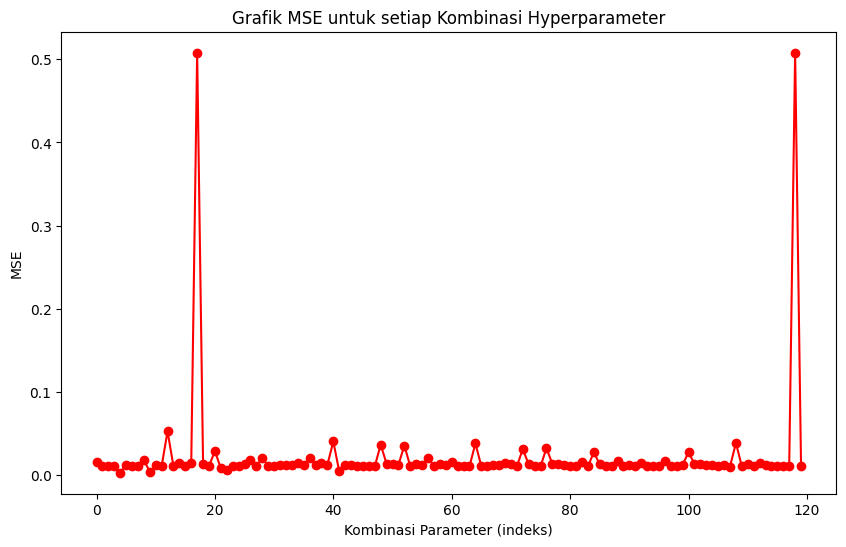

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(tuning)), tuning['mse'], marker='o', linestyle='-', color='r')
plt.title('Grafik MSE untuk setiap Kombinasi Hyperparameter')
plt.xlabel('Kombinasi Parameter (indeks)')
plt.ylabel('MSE')
plt.show()

In [12]:
tuning.to_csv('hasiltuning.csv', index=False)

In [13]:
tuning

,hidden_layer,hidden_neuron,lr,epoch,mse,bobot,bias,bobot_output,bias_output
0,1,"(1,)",0.005,200,0.015393,"[[[-17.773114260032774], [-16.597330440824585]...",[[-27.792645553701757]],[0.9392970348783936],0.636652
1,1,"(1,)",0.005,500,0.010784,"[[[-0.12743323723082114], [0.1427063273519257]...",[[-0.28328163855748106]],[0.39316265846295223],0.693171
2,1,"(1,)",0.010,200,0.010636,"[[[-8.180445363916117], [-7.4290665896757115],...",[[-11.922675517586633]],[0.38199587315873257],0.705619
3,1,"(1,)",0.010,500,0.010636,"[[[-0.9271752392234633], [-0.17888011357100875...",[[-1.3358300825074019]],[0.23142228809880838],0.705305
4,1,"(2,)",0.005,200,0.002925,"[[[1.7147371099381195, 0.14180061101759148], [...","[[0.726037694636126, -0.46380255280496685]]","[0.07372231472523018, 0.20726243096533506]",0.380854
...,...,...,...,...,...,...,...,...,...
115,2,"(5, 4)",0.010,500,0.010696,"[[[-423.05993714795636, -412.26223118909627, -...","[[0.6576176185426481, 0.2246612106067647, 0.00...","[-0.11896511685552069, -0.3293364050056321, 0....",0.914266
116,2,"(5, 5)",0.005,200,0.010600,"[[[-229.6338375979577, -186.75360798064997, -1...","[[0.1936884391574658, 0.28032513346222254, 0.0...","[0.903695009720012, 0.4086103378602904, 0.3886...",0.171579
117,2,"(5, 5)",0.005,500,0.010559,"[[[-140.84900683446617, -289.29787184052793, -...","[[0.12703587213522738, 0.23377002395005142, 0....","[0.5676797889844745, 0.5432822094455219, -0.10...",0.249275
118,2,"(5, 5)",0.010,200,0.507763,"[[[-582.264352175935, -527.8713845466777, -674...","[[0.4910151518899568, 0.8874752058136055, 0.33...","[-0.356007037424348, 0.23866901380479844, -0.1...",0.314497


In [14]:
best_index = tuning['mse'].idxmin()
best_hidden_layer_global = tuning['hidden_layer'][best_index]
best_hidden_neuron_global = tuning['hidden_neuron'][best_index]
best_lr_global = tuning['lr'][best_index]
best_epoch_global = tuning['epoch'][best_index]
best_mse_global = tuning['mse'][best_index]
best_bobot_global = tuning['bobot'][best_index]
best_bias_global = tuning['bias'][best_index]
best_bobot_output_global = tuning['bobot_output'][best_index]
best_bias_output_global = tuning['bias_output'][best_index]

print("Best Index:", best_index)
print("Best Hidden Layer:", best_hidden_layer_global)
print("Best Hidden Neuron:", best_hidden_neuron_global)
print("Best Learning Rate:", best_lr_global)
print("Best Epoch:", best_epoch_global)
print("Best MSE:", best_mse_global)
print("Best Bobot:", best_bobot_global)
print("Best Bias:", best_bias_global)
print("Best Bobot Output:", best_bobot_output_global)
print("Best Bias Output:", best_bias_output_global)

Best Index: 4
Best Hidden Layer: 1
Best Hidden Neuron: (2,)
Best Learning Rate: 0.005
Best Epoch: 200
Best MSE: 0.0029245726634881918
Best Bobot: [[[np.float64(1.7147371099381195), np.float64(0.14180061101759148)], [np.float64(2.081630145205093), np.float64(-0.18581944545960544)], [np.float64(1.7074499178051505), np.float64(0.10010768224197304)], [np.float64(1.5568152530877928), np.float64(-0.2046005104372436)]]]
Best Bias: [[0.726037694636126, np.float64(-0.46380255280496685)]]
Best Bobot Output: [np.float64(0.07372231472523018), np.float64(0.20726243096533506)]
Best Bias Output: 0.3808540729120132


### Prediksi X_test

##### Data testing

In [15]:
X_test

array([[0.72924046, 0.78047824, 0.77438659, 0.37263913],
       [0.66017316, 0.5876127 , 0.6888091 , 0.28629199],
       [0.50314837, 0.29086633, 0.48473968, 0.06663297],
       ...,
       [0.75816608, 0.77224618, 0.77558348, 0.45094435],
       [0.5733963 , 0.4880439 , 0.76181927, 0.37314462],
       [0.64285714, 0.46961976, 0.71813285, 0.29001425]])

##### Fungsi prediksi X_test

In [16]:
def predict(X_test, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_test)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_test[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Pemanggilan fungsi prediksi

In [17]:
prediksi = predict(X_test, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

##### Visualisasi hasil prediksi dan aktual

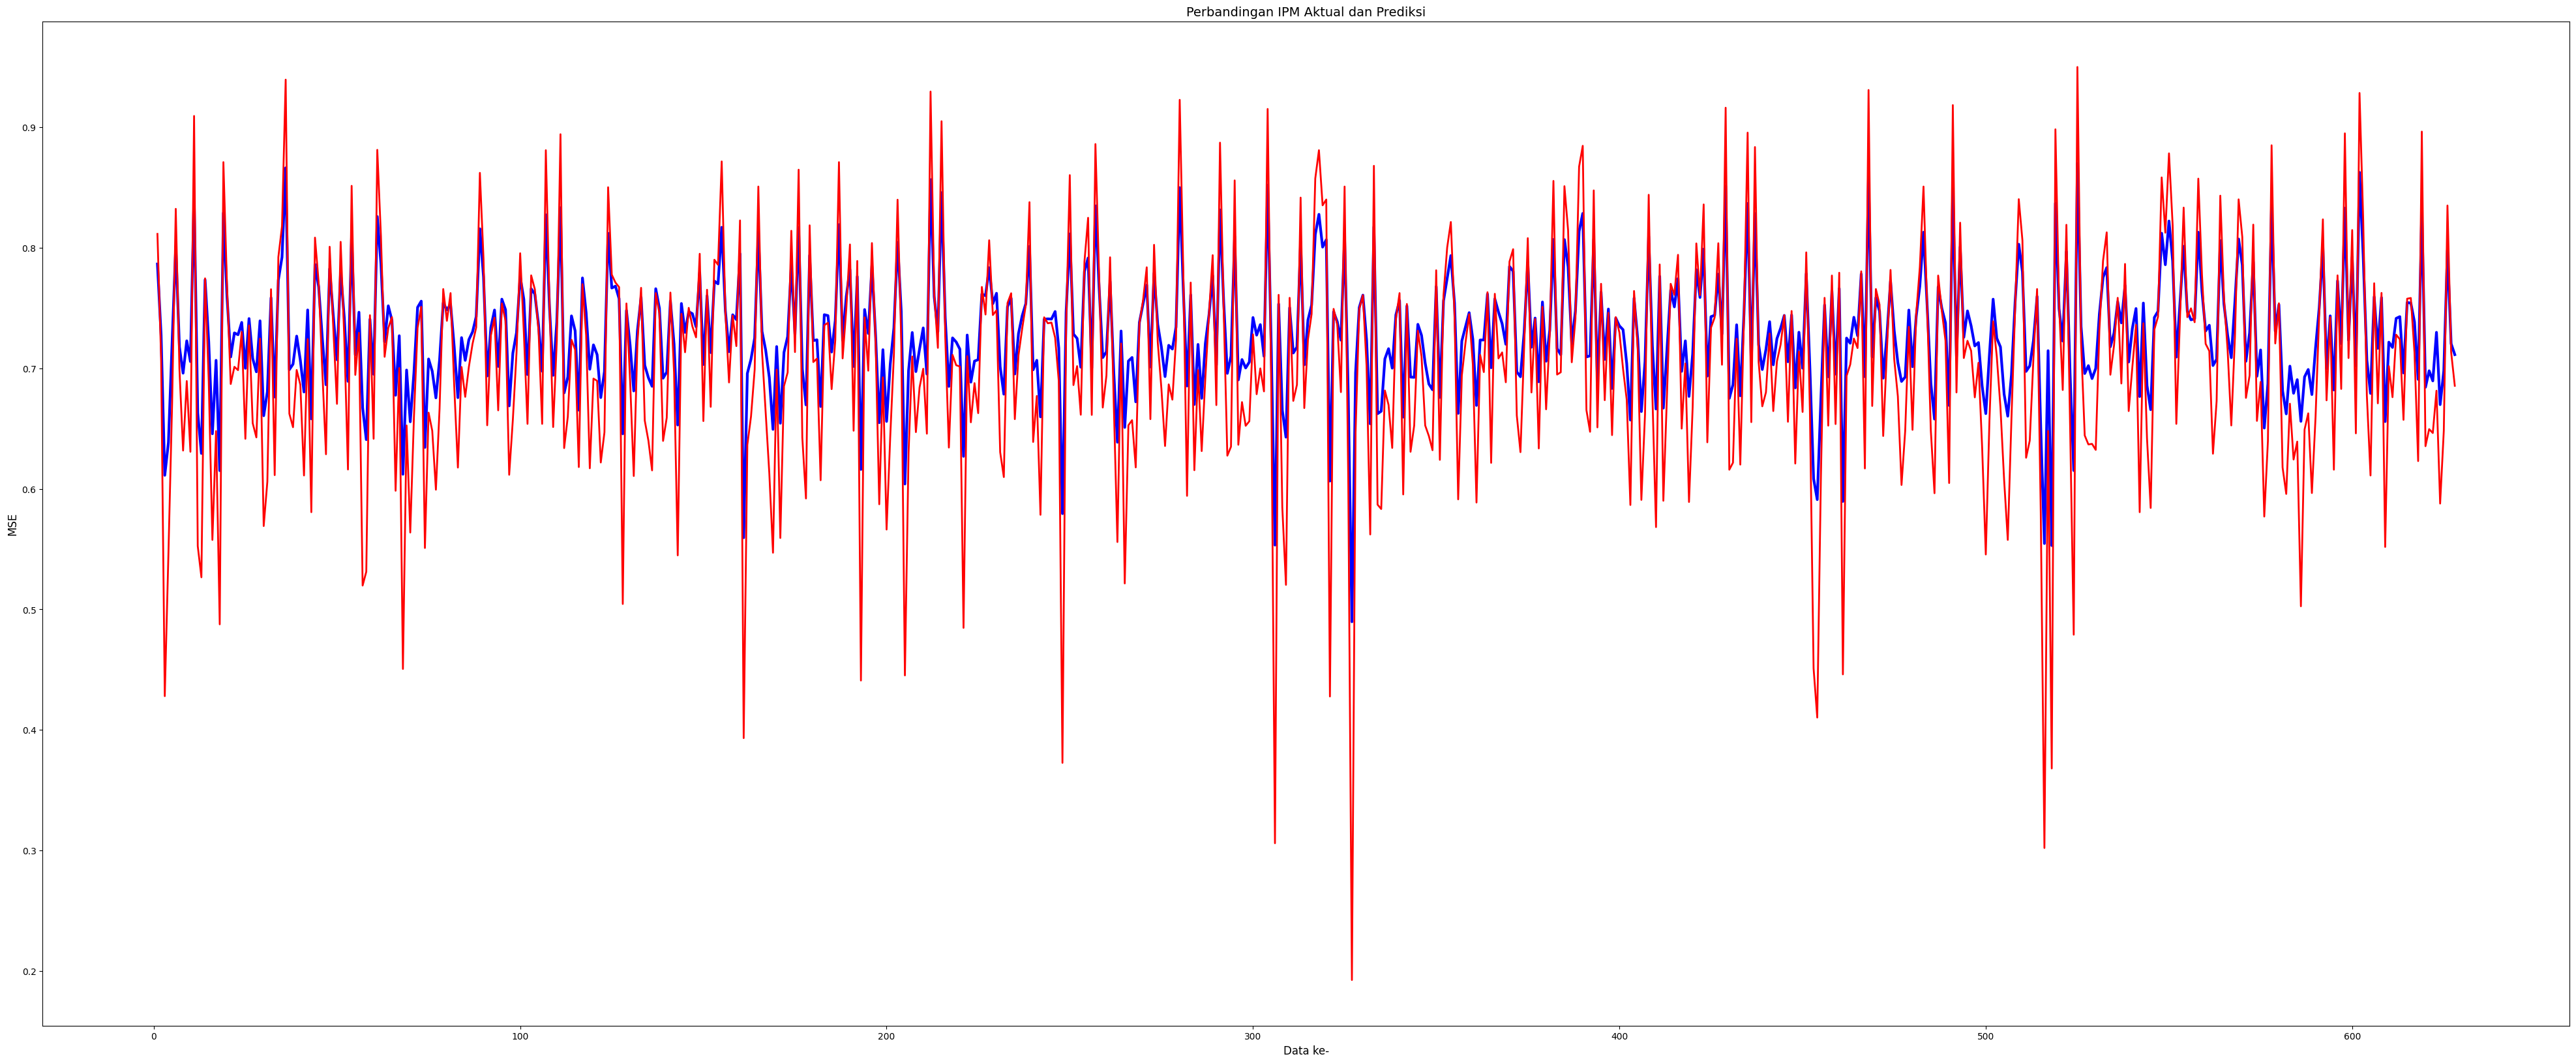

In [18]:
datake = list(range(1, len(y_test)+1))
plt.figure(figsize=(50, 20))
plt.plot(datake, prediksi, label="ipm prediksi", color='blue', linewidth=3)
plt.plot(datake, y_test, label="ipm aktual", color='red', linewidth=2)
plt.title('Perbandingan IPM Aktual dan Prediksi', fontsize=14)
plt.xlabel('Data ke-', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.show()

In [19]:
for i in range(len(y_test)):
    print(f"Aktual: {y_test[i][0]} - Prediksi: {prediksi[i]}")

Aktual: 0.8115351004951937 - Prediksi: 0.7865860859454659
Aktual: 0.7084182930381591 - Prediksi: 0.7275748517047351
Aktual: 0.4280512671133119 - Prediksi: 0.6112868007922664
Aktual: 0.546315176230702 - Prediksi: 0.6384866187890708
Aktual: 0.670404893678998 - Prediksi: 0.7209512138744258
Aktual: 0.8323623652781823 - Prediksi: 0.8012635946759867
Aktual: 0.6996795805418001 - Prediksi: 0.7177467612098161
Aktual: 0.6318089134867463 - Prediksi: 0.6960273977062225
Aktual: 0.6894844159627147 - Prediksi: 0.7228374135925857
Aktual: 0.6307893970288377 - Prediksi: 0.705674587125189
Aktual: 0.9094086804544133 - Prediksi: 0.8438933207948407
Aktual: 0.5525779201864259 - Prediksi: 0.6630796835462625
Aktual: 0.5266530731138945 - Prediksi: 0.6294345478433825
Aktual: 0.7746868628022138 - Prediksi: 0.7735287874852281
Aktual: 0.6893387707544422 - Prediksi: 0.7219976216018593
Aktual: 0.5576755024759685 - Prediksi: 0.6457335328794058
Aktual: 0.6479755316050102 - Prediksi: 0.7066692028006415
Aktual: 0.4876201

### Prediksi Data Baru

##### Fungsi prediksi data baru

In [20]:
def predict(X_new, bobot, bias, bobot_output, bias_output):
    prediksi = []
    for i in range(len(X_new)):
        # FEEDFORWARD
        # Operasi pada Hidden Layer
        aktivasi_hidden = []
        for j in range(len(bobot)):  # untuk setiap hidden layer
            aktivasi_hidden_temp = []
            for k in range(len(bobot[j][0])):  # jumlah neuron di hidden layer
                sumXbobot = 0
                if j == 0:  # layer pertama
                    for l in range(4):  # jumlah neuron input
                        sumXbobot += bobot[j][l][k] * X_new[i][l]
                else:
                    for l in range(len(aktivasi_hidden[j - 1])):
                        sumXbobot += bobot[j][l][k] * aktivasi_hidden[j - 1][l]
                sumXbobotbias = bias[j][k] + sumXbobot
                aktivasi_hidden_temp.append(relu(sumXbobotbias))
            aktivasi_hidden.append(aktivasi_hidden_temp)

        # Operasi pada Output Layer
        sumZbobotoutput = 0
        for j in range(len(aktivasi_hidden[-1])):
            sumZbobotoutput += bobot_output[j] * aktivasi_hidden[-1][j]
        sumZbobotoutput_biasoutput = bias_output + sumZbobotoutput
        predik = relu(sumZbobotoutput_biasoutput)
        prediksi.append(predik)

    return prediksi

##### Contoh prediksi

In [21]:
# angka_harapan_hidup, rerata_lama_sekolah, harapan_lama_sekolah, pengeluaran_per_kapita
X_new = [[65.655, 9.76, 14.28, 7686]]

scaler_fitur = joblib.load('fitur_mmscaler_model.pkl')
X_new_scaled = scaler_fitur.transform(X_new)

hasil_prediksi = predict(X_new_scaled, best_bobot_global, best_bias_global, best_bobot_output_global, best_bias_output_global)

scaler_target = joblib.load('target_mmscaler_y.pkl')
y_pred_original = scaler_target.inverse_transform([[hasil_prediksi[0]]])
print(y_pred_original)

[[70.13423766]]


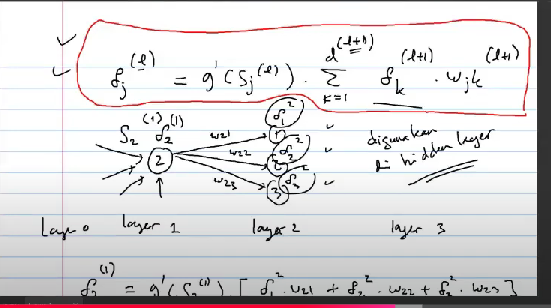

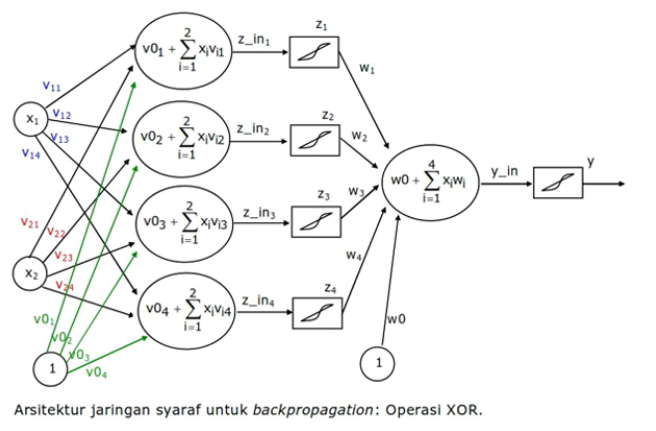